In [1]:
# 通过ARMA模型分析全国的原煤产量
# 数据来源：http://data.stats.gov.cn/easyquery.htm?cn=A01
# 通过Python进行了预处理，选取当期产量作为指标
library(forecast)
library(tseries)

In [2]:
library(readr)
coal.data <- read_csv("~/Documents/MyPrograming/R/TimeSeriesAnalysis/Projects/coal_production/coal_data.csv")

coal.ts <- ts(rev(coal.data$Num), start = c(2000,1), end=c(2017, 10),
              frequency = 12)

# 选取九年的数据
coal <- window(coal.ts, start=c(2000, 1), end=c(2009, 1))
head(coal, 12)

Parsed with column specification:
cols(
  Num = col_double(),
  Date = col_character()
)


        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
2000 6614.0 4298.2 7496.1 7044.1 7454.9 7496.2 6970.2 6986.4 7128.7 7229.6
        Nov    Dec
2000 7538.0 8682.7

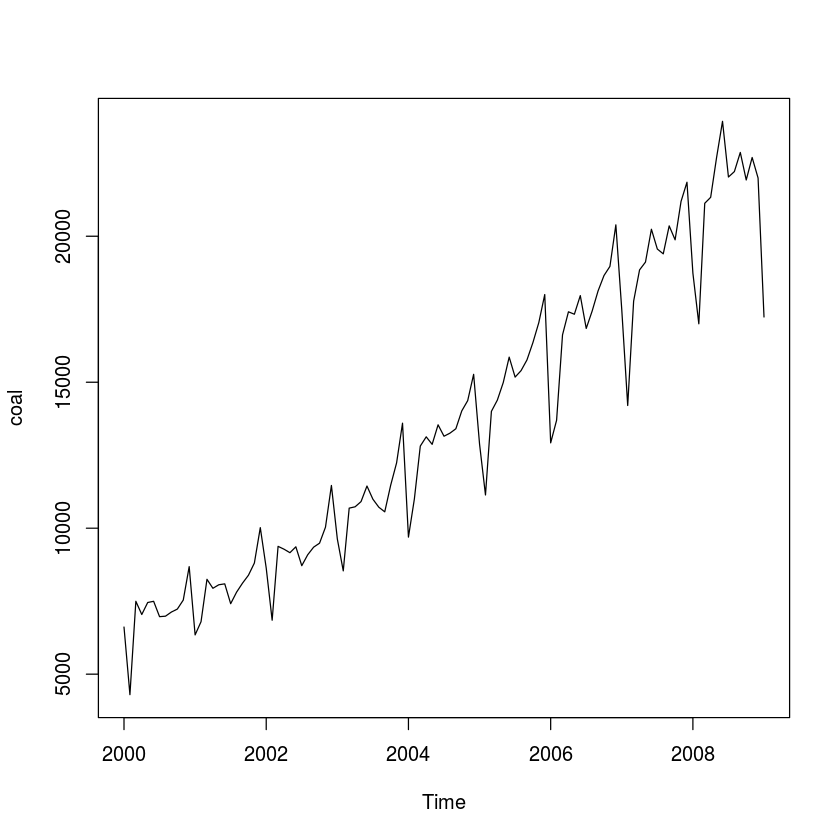

In [3]:
# 通过时序图初步观察
plot(coal)

In [4]:
# 通过上图，很显然其不是平稳的。同时，我们使用ADF进行检验，也可得到其不是平稳的。
# ADF检验
library(aTSA)
stationary.test(coal, method = "adf")


Attaching package: ‘aTSA’

The following objects are masked from ‘package:tseries’:

    adf.test, kpss.test, pp.test

The following object is masked from ‘package:forecast’:

    forecast

The following object is masked from ‘package:graphics’:

    identify



Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 0.0316   0.652
[2,]   1 0.3361   0.739
[3,]   2 1.0095   0.914
[4,]   3 1.1428   0.931
[5,]   4 2.1714   0.990
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -1.755   0.424
[2,]   1 -1.781   0.414
[3,]   2 -1.000   0.697
[4,]   3 -1.030   0.686
[5,]   4 -0.423   0.899
Type 3: with drift and trend 
     lag   ADF p.value
[1,]   0 -6.62  0.0100
[2,]   1 -6.59  0.0100
[3,]   2 -4.90  0.0100
[4,]   3 -4.98  0.0100
[5,]   4 -3.83  0.0202
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -11.57    0.01
[2,]   1 -11.17    0.01
[3,]   2  -7.52    0.01
[4,]   3  -8.51    0.01
[5,]   4  -7.14    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -11.62    0.01
[2,]   1 -11.31    0.01
[3,]   2  -7.74    0.01
[4,]   3  -9.06    0.01
[5,]   4  -8.10    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -11.57    0.01
[2,]   1 -11.25    0.01
[3,]   2  -7.69    0.01
[4,]   3  -9.00    0.01
[5,]   4  -8.03    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


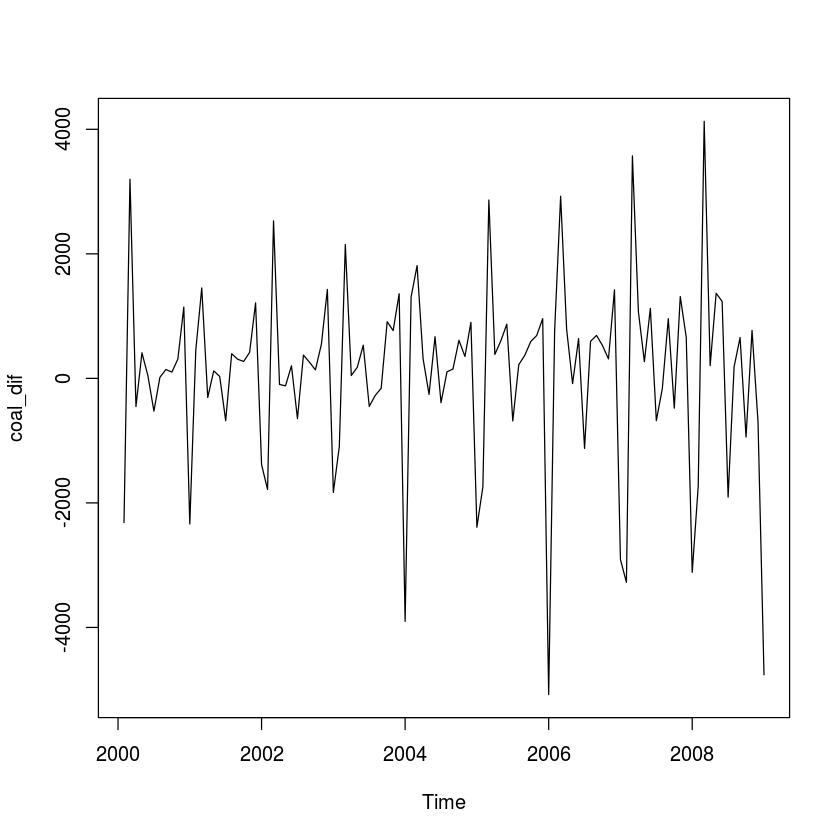

In [5]:
# 所以，我们进行差分，并对差分后的序列再次检验
diff_n = ndiffs(coal)  # 简单识别需要差分的阶数
coal_dif = diff(coal)
plot(coal_dif)  
stationary.test(coal_dif, method = "adf")

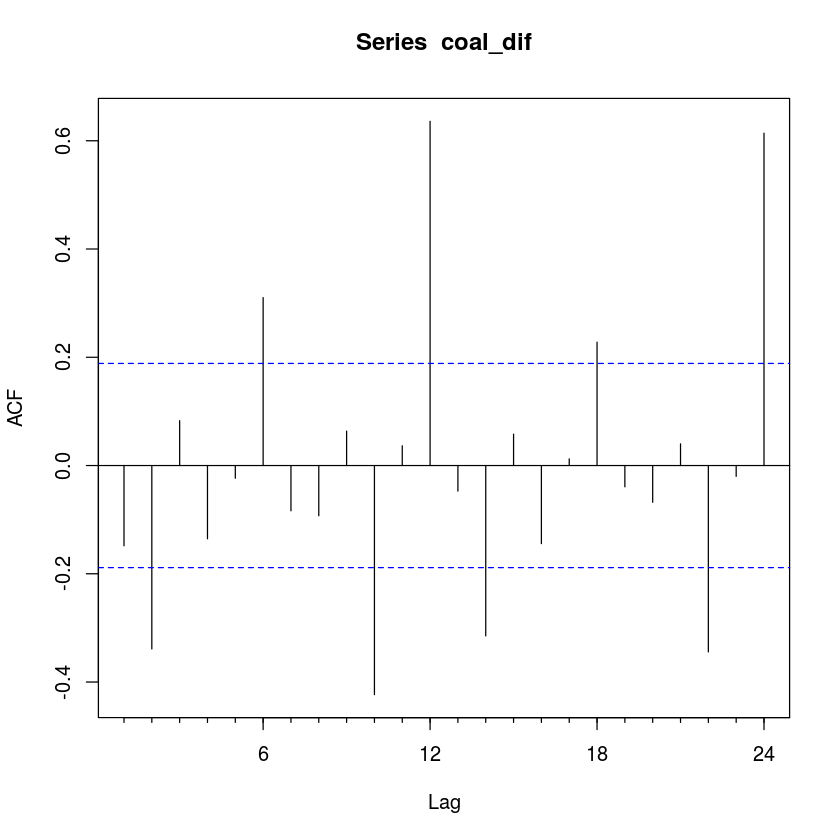

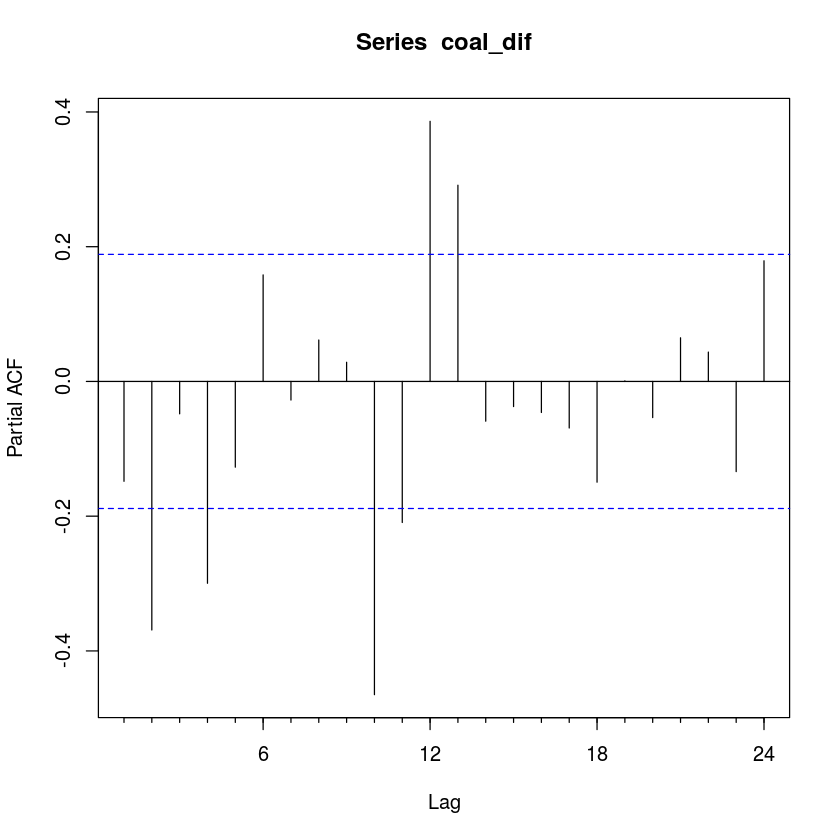

In [6]:
# 可以看到，此时已经平稳。亦即满足了ARMA建模的条件
# 下面，我们使用Box-Jenkins的方法进行建模
#　模型识别，ａｃｆ与ｐａｃｆ

Acf(coal_dif)
Pacf(coal_dif)

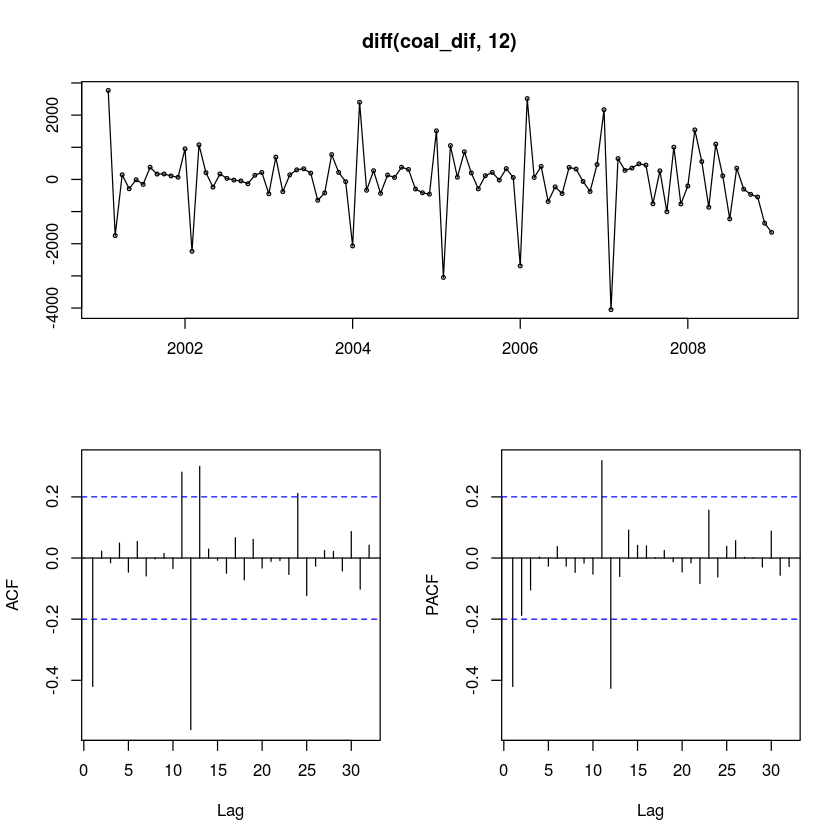

In [7]:
tsdisplay(diff(coal_dif, 12))


Call:
arima(x = coal, order = c(1, 1, 1), seasonal = c(0, 1, 1))

Coefficients:
         ar1      ma1     sma1
      0.3705  -0.8293  -0.5255
s.e.  0.1819   0.1352   0.0977

sigma^2 estimated as 564605:  log likelihood = -774.21,  aic = 1556.42

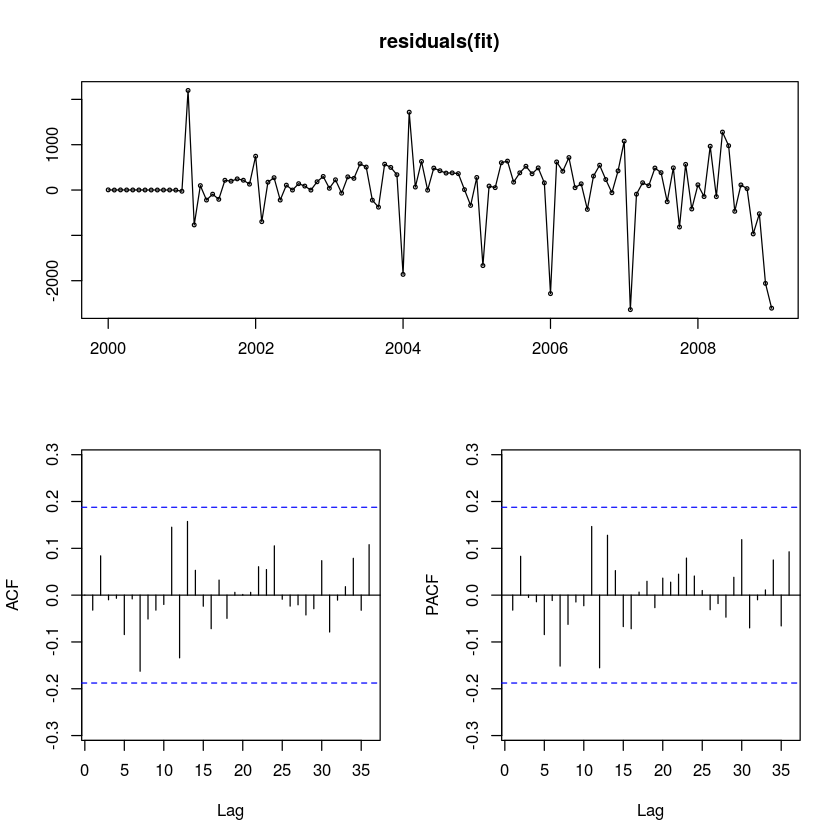

In [9]:
fit <- arima(coal, order = c(1,1,1), seasonal = c(0,1,1))
tsdisplay(residuals(fit))
fit

Series: coal 
ARIMA(1,1,0)(2,1,0)[12] 

Coefficients:
          ar1     sar1     sar2
      -0.3386  -0.7329  -0.1995
s.e.   0.1015   0.1150   0.1221

sigma^2 estimated as 527975:  log likelihood=-770.53
AIC=1549.06   AICc=1549.5   BIC=1559.32

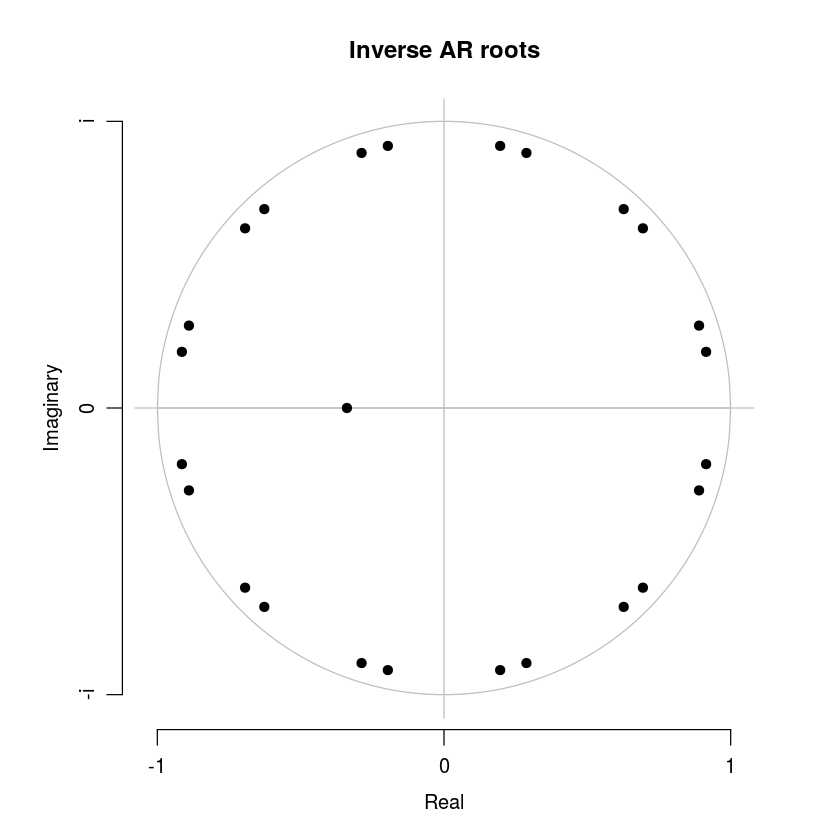

In [7]:
# 发现都是拖尾的。所以应该为ARMA模型
# 这块手动识别的理论还没有理解，直接用auto吧先...
# arima
# fit <- auto.arima(coal)
# plot(fit)
# fit

In [22]:
# 模型已经建立，下面进行模型的检验
# 残差白噪声检验(Box-Pierce test)
Box.test(fit$residuals, lag=24)


	Box-Pierce test

data:  fit$residuals
X-squared = 6.7566, df = 24, p-value = 0.9998


In [23]:
# 当然，也可以使用Box-Ljung test
Box.test(fit$residuals, type = "Ljung-Box", lag=24)


	Box-Ljung test

data:  fit$residuals
X-squared = 7.7125, df = 24, p-value = 0.9993


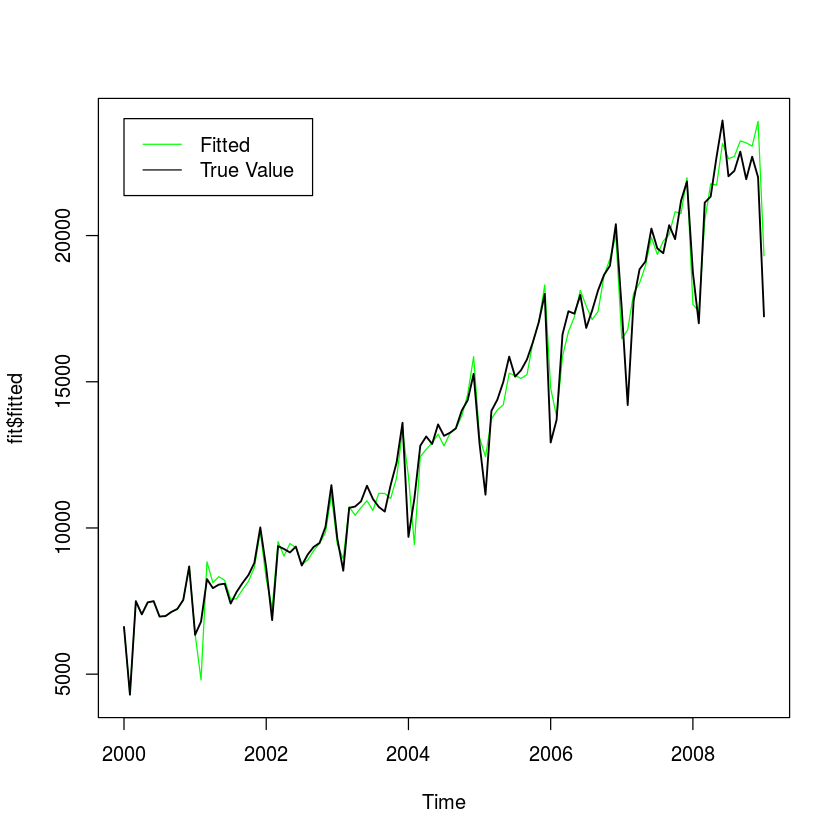

In [32]:
# 可以看到已经通过了白噪声检验，意味着拟合效果比较好
# 下面，我们作出拟合的效果图
plot(fit$fitted, col='green', lwd=1)
lines(coal, col='black', lwd=1.5)
legend(2000, 24000, 
       c("Fitted", "True Value"),
       lty=c(1,1),
       col=c("green", "black"))

In [33]:
# 可以看到，拟合效果已经是非常地好了。
# 我们还可以查看更多关于精度的信息
accuracy(fit)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-9.527188,660.5571,427.9994,0.02550494,3.206715,0.2363348,0.02761515


         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Feb 2009       15488.37 14561.85 16414.89 14071.38 16905.36
Mar 2009       19303.30 18220.54 20386.06 17647.36 20959.24
Apr 2009       20185.13 18951.74 21418.52 18298.82 22071.44
May 2009       20744.07 19377.63 22110.52 18654.27 22833.87
Jun 2009       21843.67 20355.94 23331.40 19568.38 24118.96
Jul 2009       20617.91 19018.07 22217.75 18171.17 23064.65


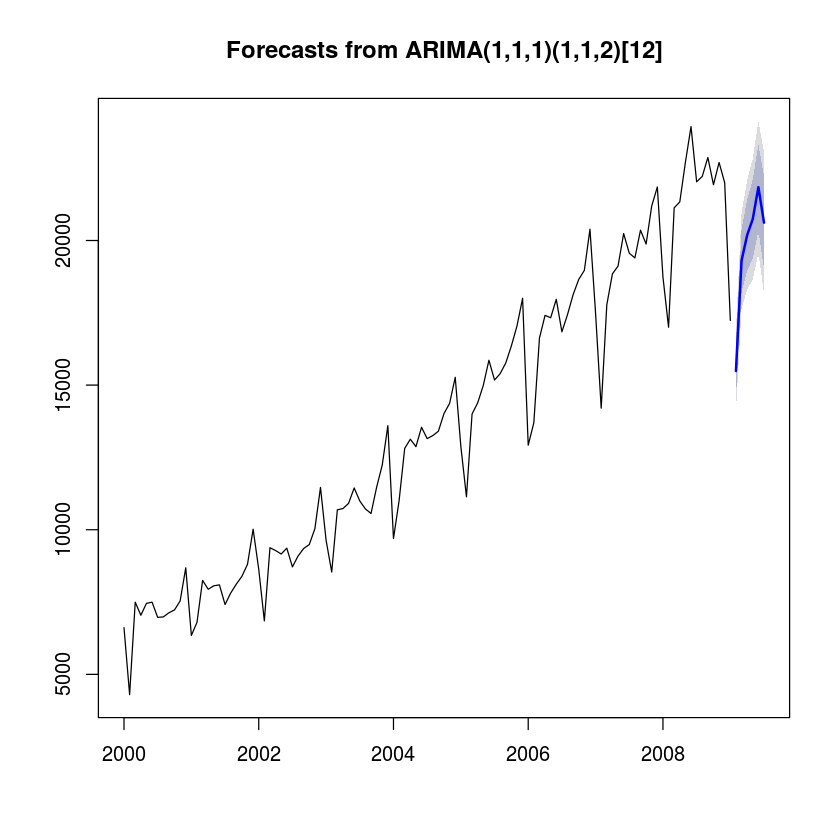

In [34]:
# 最后，我们对后面六个月的数据进行预测
# forecats
fore <- forecast::forecast(fit, h=6)
plot(fore)
print(fore)

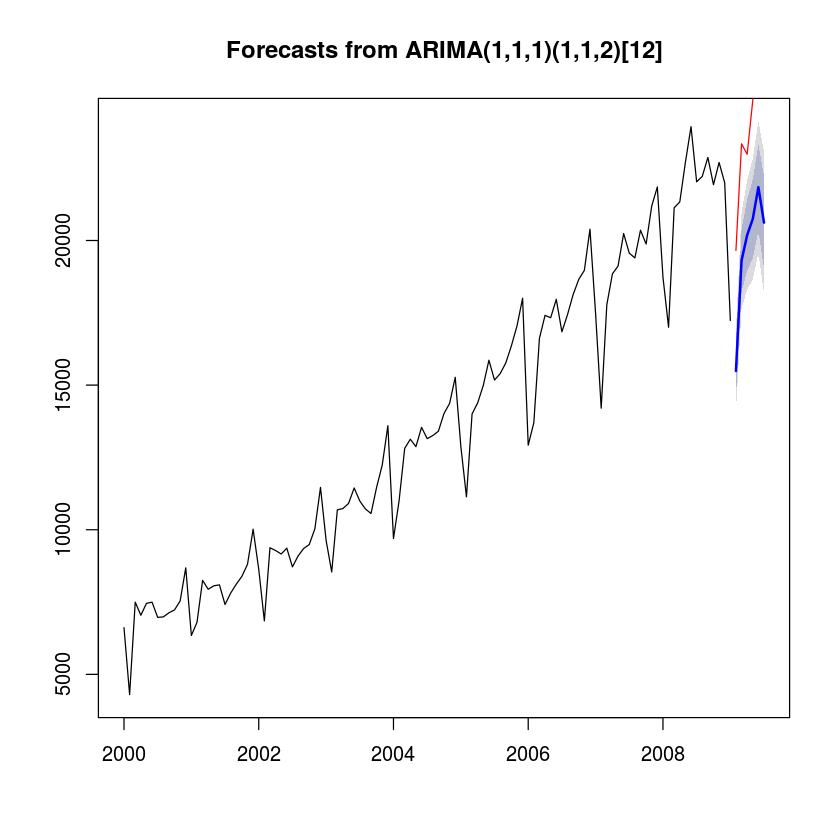

In [35]:
# 看起来一切都好的样子...
# 由于我们是有后面的真实数据的，所以我们放进去来作下对比
fore_true <- window(coal.ts, start=c(2009, 2), end=c(2009, 7))
plot(fore)
lines(fore_true, col="red")

In [36]:
# 发现差别还是比较大的...
# 我们来具体看下残差
# plot(fore$residuals)
fore_true
fore$mean

         Feb     Mar     Apr     May     Jun     Jul
2009 19656.5 23342.7 22980.0 24841.1 27908.5 25781.8

          Feb      Mar      Apr      May      Jun      Jul
2009 15488.37 19303.30 20185.13 20744.07 21843.67 20617.91

In [29]:
RMSE = sqrt(mean((fore_true-fore$mean)^2))

In [37]:
RMSE

[1] 4504.349